In [0]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import keras

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, Dropout, Add, Flatten, Dense, Reshape
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from google.colab import files
import seaborn as sns
from skimage.color import gray2rgb

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [0]:
tf.test.is_gpu_available()

False

In [0]:
!rm -r all.zip
!ls

rm: cannot remove 'all.zip': No such file or directory
sample_data


In [0]:
f=files.upload()

Saving all.zip to all.zip


In [0]:
!mkdir train
!mkdir test
!ls

mkdir: cannot create directory ‘train’: File exists
mkdir: cannot create directory ‘test’: File exists
all.zip     sample_data		   test      train	train.zip
depths.csv  sample_submission.csv  test.zip  train.csv


In [0]:
import zipfile
zip_ref = zipfile.ZipFile('all.zip', 'r')
zip_ref.extractall()
zip_ref.close()
zip_ref = zipfile.ZipFile('train.zip', 'r')
zip_ref.extractall('train')
zip_ref.close()
zip_ref = zipfile.ZipFile('test.zip', 'r')
zip_ref.extractall('test')
zip_ref.close()

In [0]:
!ls train
!pwd

images	masks
/content


In [0]:
img_size_ori = (101, 101)
img_size_target = (128, 128)
img_channels = 1
path_train_images = 'train/images/'
path_train_masks = 'train/masks/'
path_test_images = 'test/images/'

In [0]:
def upsample(img):
  return cv2.resize(img, img_size_target)
def downsample(img):
  return cv2.resize(img, img_size_ori)

In [0]:
train_df = pd.read_csv("train.csv", index_col="id")
depths_df = pd.read_csv("depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

In [0]:
train_df.head()

,rle_mask,z
id,,
575d24d81d,NaN,843
a266a2a9df,5051 5151,794
75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,468
34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,727
4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,797


In [0]:
train_df.describe()

,z
count,4000.000000
mean,506.706500
std,207.979243
min,51.000000
25%,351.000000
50%,514.000000
75%,669.000000
max,959.000000


In [0]:
train_df.shape

(4000, 2)

In [0]:
train_df["images"] = [cv2.imread(path_train_images + idx + '.png', 0) / 255 for idx in train_df.index]
train_df["masks"] = [cv2.imread(path_train_masks + idx + '.png', 0) / 255 for idx in train_df.index]

In [0]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori[0], 2)
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

In [0]:
train_df.head()

,rle_mask,z,images,masks,coverage,coverage_class
id,,,,,,
575d24d81d,NaN,843,"[[0.5254901960784314, 0.5137254901960784, 0.52...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0
a266a2a9df,5051 5151,794,"[[0.3411764705882353, 0.3764705882352941, 0.33...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.504950,6
75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,468,"[[0.5686274509803921, 0.4666666666666667, 0.32...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.993334,10
34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,727,"[[0.5411764705882353, 0.4745098039215686, 0.39...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.149201,2
4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,797,"[[0.06666666666666667, 0.0784313725490196, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.042839,1


In [0]:
train_df.columns

Index(['rle_mask', 'z', 'images', 'masks', 'coverage', 'coverage_class'], dtype='object')

Text(0.5,0,'Coverage class')

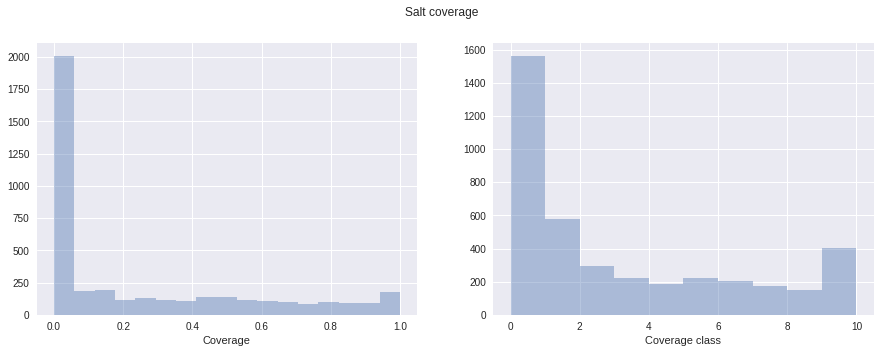

In [0]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

Text(0,0.5,'Coverage')

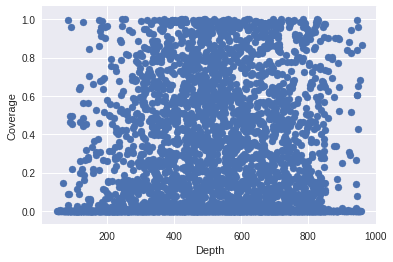

In [0]:
plt.scatter(train_df.z, train_df.coverage)
plt.xlabel("Depth")
plt.ylabel("Coverage")

Text(0.5,1,'Depth distribution')

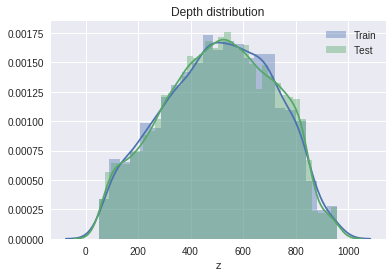

In [0]:
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

In [0]:
!apt-get remove cython
!pip install -U cython
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

In [0]:
import pydensecrf.densecrf as dcrf
from skimage.io import imread, imsave
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray

In [0]:
# DONOT USE
X_orig = np.zeros((4000, 128, 128, 2), dtype=np.float32)
Y_orig = np.zeros((4000, 128, 128, 1), dtype=np.float32)
print('Getting and resizing train images and masks ... ')
for n in range(train_df.images.shape[0]):
  x = cv2.resize(train_df.images[n], (128, 128)).reshape((128, 128, 1))
  X_orig[n] = np.dstack((x, np.full((128, 128), train_df.z[n])))
  Y_orig[n] = cv2.resize(train_df.masks[n], (128, 128)).reshape((128, 128, 1))
print("Done!")

Getting and resizing train images and masks ... 
Done!


In [0]:
X_orig = np.zeros((4000, 128, 128, 1), dtype=np.float32)
Y_orig = np.zeros((4000, 128, 128, 1), dtype=np.float32)
print('Getting and resizing train images and masks ... ')
for n in range(train_df.images.shape[0]):
  X_orig[n] = cv2.resize(train_df.images.values[n], (128, 128)).reshape((128, 128, 1))
  Y_orig[n] = cv2.resize(train_df.masks.values[n], (128, 128)).reshape((128, 128, 1))
print("Done!")

Getting and resizing train images and masks ... 
Done!


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_orig, Y_orig, test_size=0.2, stratify=train_df.coverage_class, random_state=42)

In [0]:
X_train = np.append(X_train, [x for x in X_train], axis=0)
Y_train = np.append(Y_train, [x for x in Y_train], axis=0)
X_train = np.append(X_train, [np.fliplr(x) for x in X_train], axis=0)
Y_train = np.append(Y_train, [np.fliplr(x) for x in Y_train], axis=0)
X_train = np.append(X_train, [np.flipud(x) for x in X_train], axis=0)
Y_train = np.append(Y_train, [np.flipud(x) for x in Y_train], axis=0)
#X_train = np.append(X_train, [np.rot90(x) for x in X_train], axis=0)
#Y_train = np.append(Y_train, [np.rot90(x) for x in Y_train], axis=0)

In [0]:
def mean_iou_train(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [0]:
inputs = Input((128, 128, 1))

c1 = Conv2D(32, (3, 3), activation='relu', padding='same') (inputs)
c1_ = Conv2D(32, (3, 3), activation='relu', padding='same') (c1)
c1 = concatenate([c1, c1_])
p1 = MaxPooling2D((2, 2)) (c1)
p1 = Dropout(0.5) (p1)

c2 = Conv2D(64, (3, 3), activation='relu', padding='same') (p1)
c2_ = Conv2D(64, (3, 3), activation='relu', padding='same') (c2)
c2 = concatenate([c2, c2_])
p2 = MaxPooling2D((2, 2)) (c2)
p2 = Dropout(0.5) (p2)

c3 = Conv2D(128, (3, 3), activation='relu', padding='same') (p2)
c3_ = Conv2D(128, (3, 3), activation='relu', padding='same') (c3)
c3 = concatenate([c3, c3_])
p3 = MaxPooling2D((2, 2)) (c3)
p3 = Dropout(0.5) (p3)

c4 = Conv2D(256, (3, 3), activation='relu', padding='same') (p3)
c4_ = Conv2D(256, (3, 3), activation='relu', padding='same') (c4)
c4 = concatenate([c4, c4_])
p4 = MaxPooling2D((2, 2)) (c4)
p4 = Dropout(0.5) (p4)

c5 = Conv2D(512, (3, 3), activation='relu', padding='same') (p4)
c5_ = Conv2D(512, (3, 3), activation='relu', padding='same') (c5)
c5 = concatenate([c5, c5_])

u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
u6 = Dropout(0.5)(u6)
c6 = Conv2D(256, (3, 3), activation='relu', padding='same') (u6)
c6_ = Conv2D(256, (3, 3), activation='relu', padding='same') (c6)
c6 = concatenate([c6, c6_])

u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
u7 = Dropout(0.5)(u7)
c7 = Conv2D(128, (3, 3), activation='relu', padding='same') (u7)
c7_ = Conv2D(128, (3, 3), activation='relu', padding='same') (c7)
c7 = concatenate([c7, c7_])

u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
u8 = Dropout(0.5)(u8)
c8 = Conv2D(64, (3, 3), activation='relu', padding='same') (u8)
c8_ = Conv2D(64, (3, 3), activation='relu', padding='same') (c8)
c8 = concatenate([c8, c8_])

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
u9 = Dropout(0.5)(u9)
c9 = Conv2D(16, (3, 3), activation='relu', padding='same') (u9)
c9_ = Conv2D(16, (3, 3), activation='relu', padding='same') (c9)
c9 = concatenate([c9, c9_])

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou_train])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 128, 128, 64) 0           conv2d_1[0][0]                   
                                                                 conv2d_2[0][0]                   
__________

In [0]:
if os.path.isfile('model-tgs-salt-1.h5'):
    os.remove('model-tgs-salt-1.h5')
    print('Removed old weights')

earlystopper = EarlyStopping(patience=10, verbose=1)
lr_change = ReduceLROnPlateau(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=32, epochs=500,
                    callbacks=[lr_change, checkpointer, earlystopper])

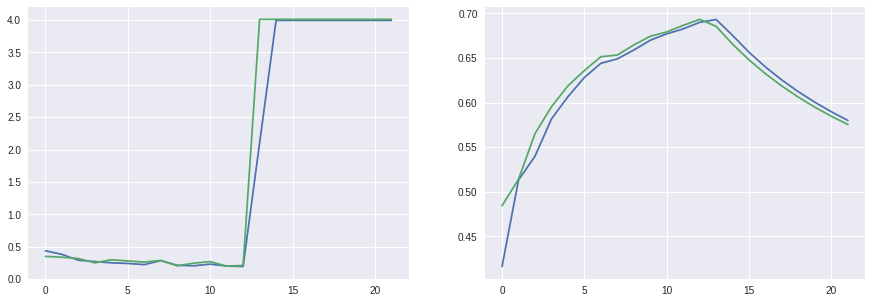

In [0]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(results.epoch, results.history["loss"], label="Train loss")
ax_loss.plot(results.epoch, results.history["val_loss"], label="Validation loss")
ax_acc.plot(results.epoch, results.history["mean_iou_train"], label="Train accuracy")
ax_acc.plot(results.epoch, results.history["val_mean_iou_train"], label="Validation accuracy")

In [0]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

preds_valid = model.predict(X_val).reshape(-1, img_size_target, img_size_target)
preds_valid = np.array([downsample(x) for x in preds_valid])
# Y_val = np.array([downsample(np.squeeze(x)) for x in Y_val])

print(preds_valid.shape)
print(np.array([downsample(np.squeeze(x)) for x in Y_val]).shape)

# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(np.array([downsample(np.squeeze(x)) for x in Y_val]), np.int32(preds_valid > threshold)) for threshold in thresholds])

threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

print(threshold_best)

(800, 101, 101)
(800, 101, 101)
0.18367346938775508


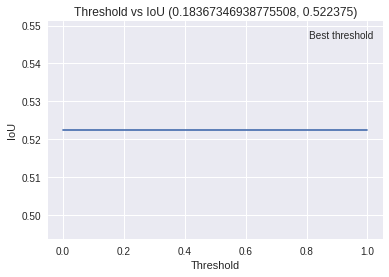

In [0]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "x", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [0]:
f = files.download('model-tgs-salt-1.h5')

In [0]:
def rle_encode(img):
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# Get and resize test images
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.float32)
print('Getting and resizing test images ... ')
for n, id_ in zip(range(len(test_ids)), test_ids):
    x = cv2.resize(cv2.imread(path_test_images + id_ , 0), (128, 128))
    X_test[n] = x.reshape((128, 128, 1))

print('Done!')

X_test = X_test/255.0

model = load_model('model-tgs-salt-1.h5', custom_objects={'mean_iou': mean_iou})
preds_test = np.squeeze(model.predict(X_test, verbose=1))
print("Before reshaping",preds_test[0].shape)
#print("After reshaping",preds_test[0])
'''
preds_test=np.round(preds_test)
print("After reshaping",preds_test[0])
'''


print("pred_dict")
pred_dict = {fn[:-4]:rle_encode((cv2.resize(preds_test[i], (101, 101)) > 0.5).astype(np.float32)) for i,fn in zip(range(len(test_ids)), test_ids)}
if os.path.isfile('submission.csv'):
    os.remove('submission.csv')
    print('Removed old submission')
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
print("Script Complete!")
print("Writing submission file")
sub.to_csv('submission.csv')
print("File ready")

In [0]:
model = keras.load_model("")